# Exercise 4: Hate Speech Classification using Multinomial Naive Bayes

Instructions:
- You do not need to split your data. Use the training, validation and test sets provided below.
- Use Multinomial Naive Bayes to train a model that can classify if a sentence is a hate speech or non-hate speech
- A sentence with a label of zero (0) is classified as non-hate speech
- A sentence with a label of one (1) is classified as a hate speech

Apply text pre-processing techniques such as
- Converting to lowercase
- Stop word Removal
- Removal of digits, special characters
- Stemming or Lemmatization but not both
- Count Vectorizer or TF-IDF Vectorizer but not both

Evaluate your model by:
- Providing input by yourself
- Creating a Confusion Matrix
- Calculating the Accuracy, Precision, Recall and F1-Score

In [4]:
import pandas as pd
from nltk.corpus import stopwords

In [5]:
splits = {'train': 'unique_train_dataset.csv', 'validation': 'unique_validation_dataset.csv', 'test': 'unique_test_dataset.csv'}

**Training Set**

Use this to train your model

In [6]:
df_train = pd.read_csv("hf://datasets/mapsoriano/2016_2022_hate_speech_filipino/" + splits["train"])

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


**Validation Set**

Use this set to evaluate your model

In [7]:
df_validation = pd.read_csv("hf://datasets/mapsoriano/2016_2022_hate_speech_filipino/" + splits["validation"])

**Test Set**
  
Use this set to test your model

In [8]:
df_test = pd.read_csv("hf://datasets/mapsoriano/2016_2022_hate_speech_filipino/" + splits["test"])

## A. Understanding your training data

1. Check the first 10 rows of the training dataset

In [9]:
df_train.head(10)

,text,label
0,Presidential candidate Mar Roxas implies that ...,1
1,Parang may mali na sumunod ang patalastas ng N...,1
2,Bet ko. Pula Ang Kulay Ng Posas,1
3,[USERNAME] kakampink,0
4,Bakit parang tahimik ang mga PINK about Doc Wi...,1
5,"""Ang sinungaling sa umpisa ay sinungaling hang...",1
6,Leni Kiko,0
7,Nahiya si Binay sa Makati kaya dito na lang sa...,1
8,Another reminderHalalan,0
9,[USERNAME] Maybe because VP Leni Sen Kiko and ...,0


2. Check how many rows and columns are in the training dataset using `.info()`

In [10]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21773 entries, 0 to 21772
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    21773 non-null  object
 1   label   21773 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 340.3+ KB


3. Check for NaN values

In [11]:
df_train.isnull().sum()

,0
text,0
label,0


4. Check for duplicate rows

In [12]:
df_train.duplicated().sum()

np.int64(0)

5. Check how many rows belong to each class

In [13]:
df_train['label'].value_counts(ascending=True)
df_train['label'].value_counts(ascending=False)

,count
label,
1,10994
0,10779


## B. Text pre-processing

6. Remove duplicate rows

In [14]:
df_train.drop_duplicates(inplace=True)
df_train.duplicated().sum()

np.int64(0)

7. Remove rows with NaN values

In [15]:
df_train.dropna(inplace=True)
df_train.isnull().sum()

,0
text,0
label,0


8. Convert all text to lowercase

In [16]:
df_train['text'] = df_train['text'].str.lower()
df_train.head(100)

,text,label
0,presidential candidate mar roxas implies that ...,1
1,parang may mali na sumunod ang patalastas ng n...,1
2,bet ko. pula ang kulay ng posas,1
3,[username] kakampink,0
4,bakit parang tahimik ang mga pink about doc wi...,1
...,...,...
95,popogi ng mga anak ngmga kandidato? yung kay b...,1
96,urrrggggbinay! aldub happy bday lola,1
97,presidential aspirants vice president [usernam...,0
98,leni4 president [username][username] never aga...,1


9. Remove digits, URLS and special characters

In [17]:
df_train['text'] = (
    df_train['text'].astype('string')
      .str.lower()
      .str.replace(r'http\S+|www\.\S+|\S+@\S+', '', regex=True, case=False)
      .str.replace(r'\d+', '', regex=True)
      .str.replace(r'[^\w\s]', '', regex=True)
      .str.replace(r'\s+', ' ', regex=True)
      .str.replace(r'[\n\t\r]', ' ', regex=True)
      .str.strip()
)

df_train.head(100)

,text,label
0,presidential candidate mar roxas implies that ...,1
1,parang may mali na sumunod ang patalastas ng n...,1
2,bet ko pula ang kulay ng posas,1
3,username kakampink,0
4,bakit parang tahimik ang mga pink about doc wi...,1
...,...,...
95,popogi ng mga anak ngmga kandidato yung kay bi...,1
96,urrrggggbinay aldub happy bday lola,1
97,presidential aspirants vice president username...,0
98,leni president usernameusername never again ma...,1


10. Remove stop words

In [18]:
import nltk
nltk.download('stopwords')

stop = set(stopwords.words('english'))

def remove_stopwords(text):
    if not text:
        return text
    tokens = text.split()
    tokens = [t for t in tokens if t not in stop]
    return ' '.join(tokens)

df_train['text'] = df_train['text'].astype('string').str.lower().apply(remove_stopwords)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


11. Use Stemming or Lemmatization

In [19]:
from nltk.stem import SnowballStemmer

stemmer = SnowballStemmer('english')

def stem_text(s):
    if not s:
        return s
    return ' '.join(stemmer.stem(tok) for tok in s.split())

df_train['text_stemmed'] = df_train['text'].astype('string').apply(stem_text)

In [20]:
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

for res in ('averaged_perceptron_tagger','wordnet','omw-1.4','punkt'):
    print(res, '->', nltk.download(res, quiet=True))

wnl = WordNetLemmatizer()

def treebank_to_wordnet_pos(tb_tag):
    if tb_tag.startswith('J'):
        return wordnet.ADJ
    if tb_tag.startswith('V'):
        return wordnet.VERB
    if tb_tag.startswith('N'):
        return wordnet.NOUN
    if tb_tag.startswith('R'):
        return wordnet.ADV
    return wordnet.NOUN

def lemmatize_text(s):
    if not s:
        return s
    tokens = nltk.word_tokenize(s)
    pos_tags = nltk.pos_tag(tokens)
    lemmas = [wnl.lemmatize(tok, treebank_to_wordnet_pos(pos)) for tok, pos in pos_tags]
    return ' '.join(t for t in lemmas if t.strip())

averaged_perceptron_tagger -> True
wordnet -> True
omw-1.4 -> True
punkt -> True


## C. Training your model

12. Put all text training data in variable **X_train**

In [21]:
x_train = df_train['text'].astype('string').fillna('')

13. Put all training data labels in variable **y_train**

In [22]:
y_train = df_train['label'].values

14. Use `CountVectorizer()` or `TfidfVectorizer()` to convert text data to its numerical form.

Put the converted data to **X_train_transformed** variable

In [23]:
from tkinter.constants import X
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

vectorizer = TfidfVectorizer(
    max_features=20000,
    ngram_range=(1,5),
    stop_words='english',
    lowercase=True,
    min_df=2
)

x_train = df_train['text'].astype('string').fillna('').tolist()
y_train = df_train['label'].values if 'label' in df_train.columns else None
x_train_transformed = vectorizer.fit_transform(x_train)

print(type(x_train_transformed))
print(x_train_transformed.shape)


<class 'scipy.sparse._csr.csr_matrix'>
(21773, 20000)


15. Create an instance of `MultinomalNB()`

In [24]:
from sklearn.naive_bayes import MultinomialNB

clf = MultinomialNB(alpha=1.0, fit_prior=True, class_prior=None)
clf.fit(x_train_transformed, y_train)

MultinomialNB()

16. Train the model using `.fit()`

In [25]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report

assert 'x_train_transformed' in globals() or 'x_train_transformed' in locals()
assert y_train is not None, "y_train is required"
assert x_train_transformed.shape[0] == len(y_train), "X and y must have same number of samples"

# create classifier and fit
clf = MultinomialNB(alpha=1.0, fit_prior=True)
clf.fit(x_train_transformed, y_train)

y_pred = clf.predict(x_train_transformed)
print("train shape:", x_train_transformed.shape)
print("train accuracy:", accuracy_score(y_train, y_pred))
print(classification_report(y_train, y_pred))

train shape: (21773, 20000)
train accuracy: 0.8645110917191017
              precision    recall  f1-score   support

           0       0.89      0.83      0.86     10779
           1       0.84      0.90      0.87     10994

    accuracy                           0.86     21773
   macro avg       0.87      0.86      0.86     21773
weighted avg       0.87      0.86      0.86     21773



## D. Evaluate your model

17. Use `.predict()` to generate model predictions using the **validation dataset**


- Put all text validation data in **X_validation** variable

- Convert **X_validation** to its numerical form.

- Put the converted data to **X_validation_transformed**

- Put all predictions in **y_validation_pred** variable

In [26]:
x_validation = df_validation['text'].astype('string').fillna('').tolist()

x_validation_transformed = vectorizer.transform(x_validation)
y_validation_pred = clf.predict(x_validation_transformed)

18. Get the Accuracy, Precision, Recall and F1-Score of the model using the **validation dataset**

- Put all validation data labels in **y_validation** variable

In [27]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

y_validation = df_validation['label'].values

y_validation_pred = clf.predict(x_validation_transformed)

accuracy = accuracy_score(y_validation, y_validation_pred)
precision = precision_score(y_validation, y_validation_pred, average='binary')
recall = recall_score(y_validation, y_validation_pred, average='binary')
f1 = f1_score(y_validation, y_validation_pred, average='binary')

print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")

Accuracy:  0.8343
Precision: 0.8082
Recall:    0.8813
F1-Score:  0.8431


19. Create a confusion matrix using the **validation dataset**

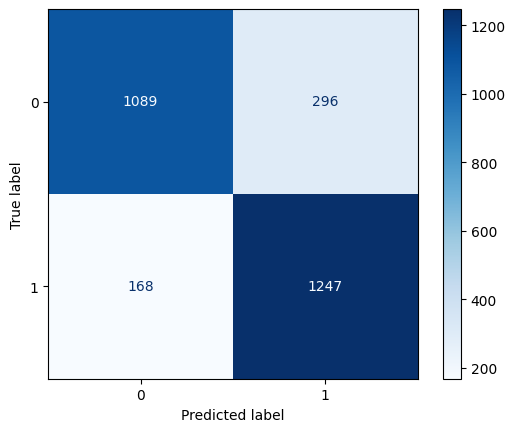

In [28]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_validation = df_validation['label'].values
y_validation_pred = clf.predict(x_validation_transformed)
cm = confusion_matrix(y_validation, y_validation_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues', values_format='d')

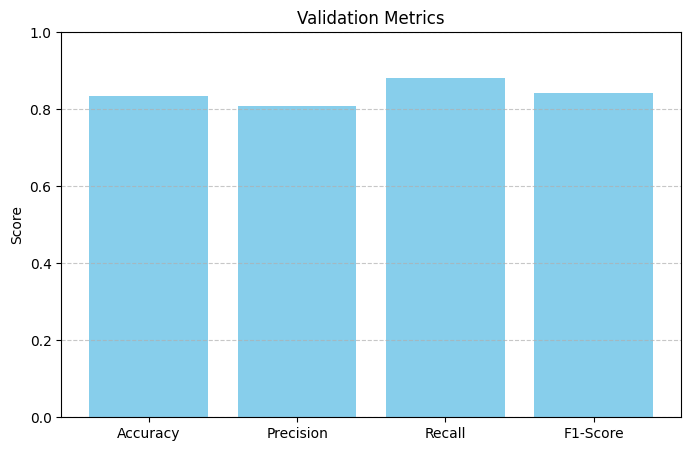

In [29]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Make sure to use the correct validation variables
y_validation = df_validation['label'].values
metrics = {
    'Accuracy': accuracy_score(y_validation, y_validation_pred),
    'Precision': precision_score(y_validation, y_validation_pred, average='binary'),
    'Recall': recall_score(y_validation, y_validation_pred, average='binary'),
    'F1-Score': f1_score(y_validation, y_validation_pred, average='binary')
}
plt.figure(figsize=(8, 5))
plt.bar(metrics.keys(), metrics.values(), color='skyblue')
plt.ylim(0, 1)
plt.title('Validation Metrics')
plt.ylabel('Score')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

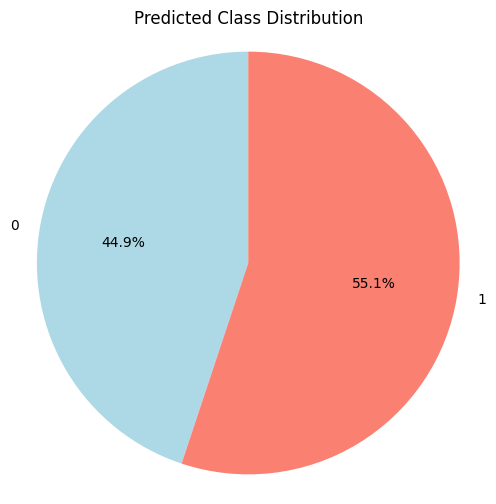

In [30]:
import matplotlib.pyplot as plt
import numpy as np

unique, counts = np.unique(y_validation_pred, return_counts=True)

plt.figure(figsize=(6, 6))
plt.pie(counts, labels=unique, autopct='%1.1f%%', startangle=90, colors=['lightblue', 'salmon'])
plt.title('Predicted Class Distribution')
plt.axis('equal')
plt.show()

20. Use `.predict()` to generate the model predictions using the **test dataset**


- Put all text validation data in **X_test** variable

- Convert **X_test** to its numerical form.

- Put the converted data to **X_test_transformed**

- Put all predictions in **y_test_pred** variable

In [31]:
X_test = df_test['text'].astype('string').fillna('').tolist()
X_test_transformed = vectorizer.transform(X_test)
y_test_pred = clf.predict(X_test_transformed)

21. Get the Accuracy, Precision, Recall and F1-Score of the model using the **test dataset**

- Put all test data labels in **y_validation** variable



In [32]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# Define X_test_transformed and y_test_pred here
X_test = df_test['text'].astype('string').fillna('').tolist()
X_test_transformed = vectorizer.transform(X_test)
y_test_pred = clf.predict(X_test_transformed)

y_validation = df_test['label'].values

accuracy = accuracy_score(y_validation, y_test_pred)
precision = precision_score(y_validation, y_test_pred, average='binary')
recall = recall_score(y_validation, y_test_pred, average='binary')
f1 = f1_score(y_validation, y_test_pred, average='binary')

print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")

Accuracy:  0.8306
Precision: 0.7974
Recall:    0.8841
F1-Score:  0.8385


22. Create a confusion matrix using the test dataset

In [33]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_validation = df_test['label'].values
y_test_pred = clf.predict(X_test_transformed)

cm = confusion_matrix(y_validation, y_test_pred)


In [34]:
X_test = df_test['text'].astype('string').fillna('').tolist()
X_test_transformed = vectorizer.transform(X_test)
y_test_pred = clf.predict(X_test_transformed)

## E. Test the model

23. Test the model by providing a non-hate speech input. The model should predict it as 0

In [35]:
sample_text = ["I love your dog"]
sample_transformed = vectorizer.transform(sample_text)
sample_pred = clf.predict(sample_transformed)

print("Predicted label:", sample_pred[0])

Predicted label: 0


24. Test the model by providing a hate speech input. The model should predict it as 1

In [38]:
sample_text = ["I dont like your shoes"]
sample_transformed = vectorizer.transform(sample_text)
sample_pred = clf.predict(sample_transformed)

print("Predicted label:", sample_pred[0])

Predicted label: 1
